Lifting coach preliminary analysis.

In [1]:
#%matplotlib qt
#%matplotlib inline
# Import basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import statistics
from scipy import stats
import itertools

# Import machine learning libraries
from sklearn.metrics import accuracy_score, cohen_kappa_score, precision_score, recall_score, roc_auc_score, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import ShuffleSplit, cross_val_score, GridSearchCV, KFold
from sklearn.preprocessing import MultiLabelBinarizer

from collections import Counter
from sklearn.metrics import confusion_matrix

In [2]:
"""
The sliding_window function uses the inputs data, events, an epoch length (seconds), overlap (percentage of overlap) and 
sample rate as a way to generate a dataframe for machine learning.
"""
def sliding_Window(data, events, epoch_Length, overlap, sample_Rate):
    
    # Trial information
    data_Header = data.columns
    number_Of_Samples = len(events) 
    trial_Length = len(events)/sample_Rate
    slide = epoch_Length - (epoch_Length*overlap)
    
    # Define Start and Stop
    n = round(((number_Of_Samples - epoch_Length*sample_Rate)/(slide*sample_Rate)),0)-1
    start = [round(x*slide, 2) for x in range(int(n))]
    stop = [round(x*slide+epoch_Length, 2) for x in range(int(n))]
    
    # Define Mean and Stardard Deviation of data during an epoch
    mean_Data = [[] for j in range(len(data.columns))]
    mean_Names = ['mean_' + x for x in data_Header]
    std_Data = [[] for k in range(len(data.columns))]
    std_Names = ['std_' + x for x in data_Header]
    
    for item in range(len(data.columns)):
        for i in range(len(start)):
            current_Mean = data.iloc[int(start[i]*sample_Rate):int(stop[i]*sample_Rate), item].mean()
            current_STD = data.iloc[int(start[i]*sample_Rate):int(stop[i]*sample_Rate), item].std()
            mean_Data[item].append(current_Mean)
            std_Data[item].append(current_STD)
    
    # Create dataframes for the data
    start_D = pd.DataFrame(start)
    start_D.columns = ['Start']
    stop_D = pd.DataFrame(stop)
    stop_D.columns = ['Stop']
    
    mean_D = pd.DataFrame(mean_Data)
    mean_D = mean_D.transpose()
    mean_D.columns = mean_Names

    std_D = pd.DataFrame(std_Data)
    std_D = std_D.transpose()
    std_D.columns = std_Names 

    revised_Data = pd.concat([start_D, stop_D, mean_D, std_D], axis=1)
    return revised_Data

#j = sliding_Window(Lift_Data, events, 1.5, 0.9, 120)

In [3]:
def sliding_Window_Events(events, epoch_Length, overlap, sample_Rate):
    number_Of_Samples = len(events) 
    trial_Length = len(events)/sample_Rate
    slide = epoch_Length - (epoch_Length*overlap)
    
    # Define Start and Stop
    n = round(((number_Of_Samples - epoch_Length*sample_Rate)/(slide*sample_Rate)),0)-1
    start = [round(x*slide, 2) for x in range(int(n))]
    stop = [round(x*slide+epoch_Length, 2) for x in range(int(n))]
    
    revised_Events = []
    for i in range(len(start)):
        current_Epoch = events.iloc[int(start[i]*sample_Rate):int(stop[i]*sample_Rate)]
        current_Event = np.bincount(current_Epoch).argmax()
        revised_Events.append(current_Event)
    
    
    event_Data = pd.DataFrame(revised_Events)
    event_Data.columns = ['Events']
    return event_Data
    
#k = sliding_Window_Events(events, 1.5, 0.9, 120)

In [4]:
def initialize_Event_Array(lengths, overlaps, list_Events, algorithms, sample_Rate):
    # Define the matrix dimensions
    maxO = max(overlaps)
    minL = min(test_Lengths)
    slide = minL - (minL*maxO)
    
    # Define Start
    number_Of_Samples = len(events)
    n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
    start = [round(x*slide, 2) for x in range(int(n))]

    
    generated_List = []
    # Create an array of zeros
    for current_Lengths in lengths:
        for current_Overlap in overlaps:
            for current_List in list_Events:
                for current_Algorithms in algorithms:
                    name = [current_List, current_Algorithms, str(current_Lengths), str(current_Overlap)]
                    current_Column = '_'.join(name)
                    generated_List.append(current_Column)
    feature_List = ['Start','Tested_Epochs', list_Events[0], list_Events[1], list_Events[2]] + generated_List
    building_Array = pd.DataFrame(0, index=np.arange(len(start)), columns=feature_List)
    building_Array['Start'] = start
    return building_Array

# test_Lengths = [1.5, 2.0, 2.5, 3.0]
# overlaps = [0.5, 0.9]
# list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
# algorithms = ['LDA', 'KNN', 'NB', 'QDA', 'LR']
# tt = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

In [5]:
def dummy_Events(events):
    # 1-Stand-Free, 3-Lift-Squat, 5-Lower-Squat
    event_Data = pd.get_dummies(events['Events'])
    event_Data.columns = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
    return event_Data

In [6]:
def change_To_Time(index, my_Epoch_Length, my_Overlap, events):
    number_Of_Samples = len(events) 
    trial_Length = len(events)/sample_Rate
    slide = my_Epoch_Length - (my_Epoch_Length*my_Overlap)
    
    # Define Start and Stop
    n = round(((number_Of_Samples - my_Epoch_Length*sample_Rate)/(slide*sample_Rate)),0)-1
    start = [round(x*slide, 2) for x in range(int(n))]

# Investigate the Data

In [7]:
# Load the data into python 
header = ['EventActNumNoZero', 'FP34okNoZero', 'FP34ok_ff_LoadOnlyNoZero', 'aLx','aLy','aLz', 'aRx','aRy','aRz']
Lift_Data = pd.read_csv("D:/DissertationNotebooks/LiftingCoach/Revised_Lifting_v3.csv")
Lift_Data.columns = header
# Sample rate 120 hz
data = Lift_Data[Lift_Data.columns[1:]]
events = Lift_Data['EventActNumNoZero']

In [8]:
Lift_Data.head()

,EventActNumNoZero,FP34okNoZero,FP34ok_ff_LoadOnlyNoZero,aLx,aLy,aLz,aRx,aRy,aRz
0,1,984.18,1.06970,0.1944,-0.0576,-0.0684,0,0,0
1,1,984.84,0.92797,-0.0720,0.0756,-0.2808,0,0,0
2,1,985.28,0.77270,-0.1620,-0.1476,0.2916,0,0,0
3,1,985.48,0.60231,-0.0540,-0.0864,0.2916,0,0,0
4,1,985.46,0.41579,0.0540,0.0144,-0.2412,0,0,0


In [9]:
#select_Data = Lift_Data['FP34okNoZero', 'FP34ok_ff_LoadOnlyNoZero', 'aLx', 'aRx']
select_Data = Lift_Data[['FP34ok_ff_LoadOnlyNoZero', 'aLx','aLy','aLz', 'aRx','aRy','aRz']]

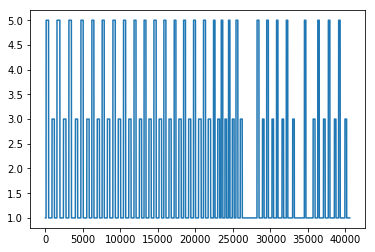

In [10]:
plt.figure(2)
time = Lift_Data.index.values
listed_Event = Lift_Data['EventActNumNoZero']
plt.plot(time, listed_Event)

In [11]:
# Run this for MultiClassification
# Create empty lists to append to.
names = []
Event = []
Chance = []
Overlap = []
Lengths = []
Accuracy = []
TestAcc = []
Precision = []
Recall = []
Kappa = []

# Create test conditions to go into the loop
#test_Lengths = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
#overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

test_Lengths = [2.5]
overlaps = [0.9]
list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
#algorithms = ['LDA', 'KNN', 'NB', 'QDA', 'LR', 'SVC']
algorithms = ['KNN']
#cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv = KFold(5)
# Add stratified data split


events_Array = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

# Create numpy arrays 
total_Trial_Pred = np.array([])
total_Trial_Test = np.array([])

for my_Epoch_Length in test_Lengths:
    for my_Overlap in overlaps:
        

        # Create dataset for machine learning
        labels = sliding_Window_Events(events, my_Epoch_Length, my_Overlap, 120)
        event = dummy_Events(labels)
        chosen_Event = labels  # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
        #chosen_Event = event[my_Event] # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
        #current_Event = my_Event
        #n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
        data_Frame = pd.DataFrame(sliding_Window(data, events, my_Epoch_Length, my_Overlap, 120))
        data_Only = data_Frame[data_Frame.columns[2:]]
        #data_Only = select_Data
        
        #pca = decomposition.PCA(n_components=0.95)

        # Define the parameters
        #svcParameters = [{'gamma': 10.0 ** np.arange(-5, 4), 'C': 10.0 ** np.arange(-2, 7)}]
        #ldaParameters = [{'n_components' : [10, 20, 30, 40], 'solver': ['svd', 'lsqr', 'eigen']}]
        ldaParameters = [{'n_components' : [3, 4, 5, 6], 'solver': ['svd', 'lsqr', 'eigen']}]
        knnParameters = [{'n_neighbors' : [5, 10, 15, 20]}]
        #knnParameters = [{'n_neighbors' : [50, 100, 150, 200]}]
        
        # Assemble default classifiers
        #svc = SVC(probability=True)
        lda = LinearDiscriminantAnalysis()
        knn = KNeighborsClassifier()
        nb = GaussianNB()
        qda = QuadraticDiscriminantAnalysis()
        lr = LogisticRegression()

        # Assemble grid parameter classifiers
        #svc2 = GridSearchCV(SVC(probability=True), svcParameters, cv=cv, scoring='accuracy')
        lda2 = GridSearchCV(LinearDiscriminantAnalysis(), ldaParameters, cv=cv, scoring='accuracy')
        knn2 = GridSearchCV(KNeighborsClassifier(), knnParameters, cv=cv, scoring='accuracy')

        # Split the test and train datasets
        for train_idx, test_idx in cv.split(labels):
            y_train, y_test = chosen_Event.loc[train_idx], chosen_Event.loc[test_idx]
            X_train, X_test = data_Only.loc[train_idx,:], data_Only.loc[test_idx,:]
            
            
            #total_Trial_Test.append(y_test)

        # Perform the machine learning
        currentName = algorithms
        #classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)]), Pipeline([('NB', nb)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
        classifier = [Pipeline([('KNN', knn)])]
        #classifier = [Pipeline([('LDA', lda)])]
        #classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)])]
        count = 0
        for my_Classifier in classifier:
            sAccuracy = cross_val_score(my_Classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=1)

            # Printing the results
            labels = chosen_Event
            #class_balance = np.mean(labels == labels[0])
            #class_balance = np.mean(labels)
            #class_balance = max(class_balance, 1. - class_balance)
            y_pred = my_Classifier.fit(X_train, y_train).predict(X_test)
            y_pred_prob = my_Classifier.predict_proba(X_test)
            #y_pred_class = binarize(y_pred_prob, 0.5)[:,0] # Predict events labeled as 1 not 2 which in this case is zero.

            #rocTest = (1-y_test)+1
            #auc = roc_auc_score(rocTest, y_pred_class)
            tacc = accuracy_score(y_test, y_pred)
            #prec = precision_score(y_test, y_pred)
            #recall = recall_score(y_test, y_pred)
            #kappa = cohen_kappa_score(y_test, y_pred)

            names.append(currentName[count])
            #Event.append(current_Event)
            Lengths.append(my_Epoch_Length)
            #Chance.append(class_balance)
            Overlap.append(my_Overlap)
            Accuracy.append(np.mean(sAccuracy))
            TestAcc.append(tacc)
            #Precision.append(prec)
            #Recall.append(recall)
            #AUC.append(auc)
            #Kappa.append(kappa)
            count = count + 1

            #header_Name = [my_Event, list(my_Classifier.named_steps.keys())[0], str(my_Epoch_Length), str(my_Overlap)]
            #current_Column = '_'.join(header_Name)

        # Create a data frame that appends new columns
        # Reprint the events
        
        
        #true_Events = y_test
        #current_Prediction = y_pred
        
            

# #myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Chance' : Chance, 'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall, 'AUC' : AUC, 'Kappa': Kappa}
# myData = {'Name' : names, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall,  'Kappa': Kappa}

# test5 = pd.DataFrame(myData, columns = ['Name', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc', 'Precision', 'Recall', 'Kappa'])
# #test5.to_csv('testing.csv')

myData = {'Name' : names, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc}

test5 = pd.DataFrame(myData, columns = ['Name', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc'])
#test5.to_csv('revised_Test.csv')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\pipeline.py:250: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params)
C:\Program Files (x86)\Microsoft Visual Studio\Shared\A

In [12]:
test5

,Name,Epochs,Overlap,Accuracy,TestAcc
0,KNN,2.5,0.9,0.725303,0.895522


In [13]:
train_idx.shape

(1074,)

In [45]:
test_idx.shape

(223,)

In [47]:
sAccuracy.

array([0.51396648, 0.5698324 , 0.54748603, 0.56741573, 0.7247191 ])

In [ ]:
# Run this for MultiClassification
# Create empty lists to append to.
names = []
Event = []
Chance = []
Overlap = []
Lengths = []
Accuracy = []
TestAcc = []
Precision = []
Recall = []
Kappa = []

# Create test conditions to go into the loop
test_Lengths = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
#overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

#test_Lengths = [2.5]
overlaps = [0.9]
list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
algorithms = ['LDA', 'KNN', 'NB', 'QDA', 'LR', 'SVC']
#algorithms = ['KNN']
#cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv = KFold(5)
# Add stratified data split


events_Array = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

for my_Epoch_Length in test_Lengths:
    for my_Overlap in overlaps:

        # Create dataset for machine learning
        labels = sliding_Window_Events(events, my_Epoch_Length, my_Overlap, 120)
        event = dummy_Events(labels)
        chosen_Event = labels  # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
        #chosen_Event = event[my_Event] # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
        #current_Event = my_Event
        #n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
        data_Frame = pd.DataFrame(sliding_Window(data, events, my_Epoch_Length, my_Overlap, 120))
        data_Only = data_Frame[data_Frame.columns[2:]]
        #data_Only = select_Data
        
        #pca = decomposition.PCA(n_components=0.95)

        # Define the parameters
        #svcParameters = [{'gamma': 10.0 ** np.arange(-5, 4), 'C': 10.0 ** np.arange(-2, 7)}]
        #ldaParameters = [{'n_components' : [10, 20, 30, 40], 'solver': ['svd', 'lsqr', 'eigen']}]
        ldaParameters = [{'n_components' : [3, 4, 5, 6], 'solver': ['svd', 'lsqr', 'eigen']}]
        #knnParameters = [{'n_neighbors' : [5, 10, 15, 20]}]
        knnParameters = [{'n_neighbors' : [50, 100, 150, 200]}]
        
        # Assemble default classifiers
        #svc = SVC(probability=True)
        lda = LinearDiscriminantAnalysis()
        knn = KNeighborsClassifier()
        nb = GaussianNB()
        qda = QuadraticDiscriminantAnalysis()
        lr = LogisticRegression()

        # Assemble grid parameter classifiers
        #svc2 = GridSearchCV(SVC(probability=True), svcParameters, cv=cv, scoring='accuracy')
        lda2 = GridSearchCV(LinearDiscriminantAnalysis(), ldaParameters, cv=cv, scoring='accuracy')
        knn2 = GridSearchCV(KNeighborsClassifier(), knnParameters, cv=cv, scoring='accuracy')

        # Split the test and train datasets
        for train_idx, test_idx in cv.split(labels):
            y_train, y_test = chosen_Event.loc[train_idx], chosen_Event.loc[test_idx]
            X_train, X_test = data_Only.loc[train_idx,:], data_Only.loc[test_idx,:]

        # Perform the machine learning
        currentName = algorithms
        classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)]), Pipeline([('NB', nb)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
        #classifier = [Pipeline([('KNN', knn)])]
        #classifier = [Pipeline([('LDA', lda)])]
        count = 0
        for my_Classifier in classifier:
            sAccuracy = cross_val_score(my_Classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=1)

            # Printing the results
            labels = chosen_Event
            #class_balance = np.mean(labels == labels[0])
            #class_balance = np.mean(labels)
            #class_balance = max(class_balance, 1. - class_balance)
            y_pred = my_Classifier.fit(X_train, y_train).predict(X_test)
            y_pred_prob = my_Classifier.predict_proba(X_test)
            #y_pred_class = binarize(y_pred_prob, 0.5)[:,0] # Predict events labeled as 1 not 2 which in this case is zero.

            #rocTest = (1-y_test)+1
            #auc = roc_auc_score(rocTest, y_pred_class)
            tacc = accuracy_score(y_test, y_pred)
            #prec = precision_score(y_test, y_pred)
            #recall = recall_score(y_test, y_pred)
            #kappa = cohen_kappa_score(y_test, y_pred)

            names.append(currentName[count])
            #Event.append(current_Event)
            Lengths.append(my_Epoch_Length)
            #Chance.append(class_balance)
            Overlap.append(my_Overlap)
            Accuracy.append(np.mean(sAccuracy))
            TestAcc.append(tacc)
            #Precision.append(prec)
            #Recall.append(recall)
            #AUC.append(auc)
            #Kappa.append(kappa)
            count = count + 1

            #header_Name = [my_Event, list(my_Classifier.named_steps.keys())[0], str(my_Epoch_Length), str(my_Overlap)]
            #current_Column = '_'.join(header_Name)

        # Create a data frame that appends new columns
        # Reprint the events
        true_Events = y_test
        current_Prediction = y_pred
        
            

# #myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Chance' : Chance, 'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall, 'AUC' : AUC, 'Kappa': Kappa}
# myData = {'Name' : names, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall,  'Kappa': Kappa}

# test5 = pd.DataFrame(myData, columns = ['Name', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc', 'Precision', 'Recall', 'Kappa'])
# #test5.to_csv('testing.csv')

myData = {'Name' : names, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc}

test5 = pd.DataFrame(myData, columns = ['Name', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc'])
test5.to_csv('revised_Test.csv')

In [142]:
knn2sec = {'TrueEvents': y_test, 'PredictedEvents': current_Prediction}
result_DF = pd.DataFrame(knn2sec, columns = ['TrueEvents', 'PredictedEvents'])
result_DF.to_csv('knn2sec.csv')

In [150]:
plt.figure(6)
time = y_test.index.values
plt.plot(time, y_test, 'b')
plt.plot(time, y_pred, 'r')

In [133]:
# Find the best setting
# Create a confusion matrix from the best setting
#class_names = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
class_names = ['Stand_Free', 'Lower_Squat', 'Lift_Squat']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

Confusion matrix, without normalization
[[221   9  25]
 [  4  34   9]
 [  3   4  27]]
Normalized confusion matrix
[[0.87 0.04 0.1 ]
 [0.09 0.72 0.19]
 [0.09 0.12 0.79]]


In [137]:
y_test

,Events
1344,1
1345,1
1346,1
1347,1
1348,1
1349,1
1350,1
1351,1
1352,1
1353,1


In [78]:
# 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
rename = labels
rename[rename == 1] = 'Stand_Free'
rename[rename == 3] = 'Lift_Squat'
rename[rename == 5] = 'Lower_Squat'
rename.head()

,Events
0,Lower_Squat
1,Lower_Squat
2,Lower_Squat
3,Stand_Free
4,Stand_Free


For the purpose of this preliminary data, I will focus on the variables that can be obtained from the wearable sensors. These variables include LoadOnly, aCOM_TNH_x, aCOM_TNH_y, aCOM_TNH_z, aLHAND_x, aLHAND_y, aLHAND_z, aLANK_x, aLANK_y and aLANK_z.

In [18]:
# Create empty lists to append to.
names = []
Event = []
Chance = []
Overlap = []
Lengths = []
Accuracy = []
TestAcc = []
Precision = []
Recall = []
Kappa = []

# Create test conditions to go into the loop
#test_Lengths = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
#overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

test_Lengths = [2.0]
overlaps = [0.5, 0.9]
list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
algorithms = ['LDA', 'KNN', 'NB', 'QDA', 'LR']
cv = ShuffleSplit(5, test_size=0.2, random_state=42)

# Add stratified data split


events_Array = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

for my_Event in list_Events:
    for my_Epoch_Length in test_Lengths:
        for my_Overlap in overlaps:

            # Create dataset for machine learning
            labels = sliding_Window_Events(events, my_Epoch_Length, my_Overlap, 120)
            event = dummy_Events(labels)
            chosen_Event = event[my_Event] # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
            current_Event = my_Event
            #n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
            data_Frame = pd.DataFrame(sliding_Window(data, events, my_Epoch_Length, my_Overlap, 120))
            data_Only = data_Frame[data_Frame.columns[2:]]

            # Define the parameters
            svcParameters = [{'gamma': 10.0 ** np.arange(-5, 4), 'C': 10.0 ** np.arange(-2, 7)}]
            ldaParameters = [{'n_components' : [10, 20, 30, 40], 'solver': ['svd', 'lsqr', 'eigen']}]
            knnParameters = [{'n_neighbors' : [5, 10, 15, 20]}]
            #artParameters = [{'max_features' : [2, 4, 6, 8, 10]}]
            #fParameters = [{'max_features': ["sqrt", "log2", None, 1], 'max_depth':[None, 15, 30, 50], 'min_samples_leaf': [2, 5, 10]}]

            # Assemble default classifiers
            svc = SVC(probability=True)
            lda = LinearDiscriminantAnalysis()
            knn = KNeighborsClassifier()
            #cart = DecisionTreeClassifier()
            nb = GaussianNB()
            qda = QuadraticDiscriminantAnalysis()
            lr = LogisticRegression()
            #rf = RandomForestClassifier()

            # Assemble grid parameter classifiers
            svc2 = GridSearchCV(SVC(probability=True), svcParameters, cv=cv, scoring='accuracy')
            lda2 = GridSearchCV(LinearDiscriminantAnalysis(), ldaParameters, cv=cv, scoring='accuracy')
            knn2 = GridSearchCV(KNeighborsClassifier(), knnParameters, cv=cv, scoring='accuracy')
            #cart2 = GridSearchCV(DecisionTreeClassifier(), cartParameters, cv=cv, scoring='accuracy')
            #nb2 = GridSearchCV(GaussianNB(), nbParameters, cv=cv, scoring='accuracy')
            #qda2 = GridSearchCV(QuadraticDiscriminantAnalysis(), qdaParameters, cv=cv, scoring='accuracy')
            #rf2 = GridSearchCV(RandomForestClassifier(), rfParameters, cv=cv, scoring='accuracy')
            
            # Split the test and train datasets
            for train_idx, test_idx in cv.split(labels):
                y_train, y_test = chosen_Event.loc[train_idx], chosen_Event.loc[test_idx]
                X_train, X_test = data_Only.loc[train_idx,:], data_Only.loc[test_idx,:]
                
            # Perform the machine learning
            currentName = algorithms
            #currentName = ['LDA']
            #classifier = [ Pipeline([('KNN', knn2)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)]), Pipeline([('NB', nb)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            #classifier = [Pipeline([('LDA', lda)])]
            count = 0
            for my_Classifier in classifier:
                sAccuracy = cross_val_score(my_Classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=1)

                # Printing the results
                labels = chosen_Event
                class_balance = np.mean(labels == labels[0])
                class_balance = np.mean(labels)
                class_balance = max(class_balance, 1. - class_balance)
                y_pred = my_Classifier.fit(X_train, y_train).predict(X_test)
                y_pred_prob = my_Classifier.predict_proba(X_test)
                #y_pred_class = binarize(y_pred_prob, 0.5)[:,0] # Predict events labeled as 1 not 2 which in this case is zero.

                rocTest = (1-y_test)+1
                #auc = roc_auc_score(rocTest, y_pred_class)
                tacc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                kappa = cohen_kappa_score(y_test, y_pred)

                names.append(currentName[count])
                Event.append(current_Event)
                Lengths.append(my_Epoch_Length)
                Chance.append(class_balance)
                Overlap.append(my_Overlap)
                Accuracy.append(np.mean(sAccuracy))
                TestAcc.append(tacc)
                Precision.append(prec)
                Recall.append(recall)
                #AUC.append(auc)
                Kappa.append(kappa)
                count = count + 1
                
                header_Name = [my_Event, list(my_Classifier.named_steps.keys())[0], str(my_Epoch_Length), str(my_Overlap)]
                current_Column = '_'.join(header_Name)
                
                
                # Fix This
                #events_Array['tested_Column'][[test_idx]] = 1
                #events_Array[current_Column][[test_idx]] = y_pred
                
            # Create a data frame that appends new columns
            # Reprint the events
            #true_Events = y_test
            

#myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Chance' : Chance, 'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall, 'AUC' : AUC, 'Kappa': Kappa}
myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall,  'Kappa': Kappa}

test5 = pd.DataFrame(myData, columns = ['Name', 'Event', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc', 'Precision', 'Recall', 'Kappa'])
#test5.to_csv('testing.csv')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

In [24]:
# Create empty lists to append to.
names = []
Event = []
Chance = []
Overlap = []
Lengths = []
Accuracy = []
TestAcc = []
Precision = []
Recall = []
Kappa = []

# Create test conditions to go into the loop
#test_Lengths = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
#overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

test_Lengths = [2.0]
overlaps = [0.5, 0.9]
list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
algorithms = ['LDA', 'KNN', 'NB', 'LR']
#cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv = KFold(5)
# Add stratified data split


events_Array = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

for my_Event in list_Events:
    for my_Epoch_Length in test_Lengths:
        for my_Overlap in overlaps:

            # Create dataset for machine learning
            labels = sliding_Window_Events(events, my_Epoch_Length, my_Overlap, 120)
            event = dummy_Events(labels)
            chosen_Event = event[my_Event] # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
            current_Event = my_Event
            #n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
            data_Frame = pd.DataFrame(sliding_Window(data, events, my_Epoch_Length, my_Overlap, 120))
            data_Only = data_Frame[data_Frame.columns[2:]]

            # Define the parameters
            svcParameters = [{'gamma': 10.0 ** np.arange(-5, 4), 'C': 10.0 ** np.arange(-2, 7)}]
            ldaParameters = [{'n_components' : [10, 20, 30, 40], 'solver': ['svd', 'lsqr', 'eigen']}]
            knnParameters = [{'n_neighbors' : [5, 10, 15, 20]}]
            #artParameters = [{'max_features' : [2, 4, 6, 8, 10]}]
            #fParameters = [{'max_features': ["sqrt", "log2", None, 1], 'max_depth':[None, 15, 30, 50], 'min_samples_leaf': [2, 5, 10]}]

            # Assemble default classifiers
            svc = SVC(probability=True)
            lda = LinearDiscriminantAnalysis()
            knn = KNeighborsClassifier()
            #cart = DecisionTreeClassifier()
            nb = GaussianNB()
            qda = QuadraticDiscriminantAnalysis()
            lr = LogisticRegression()
            #rf = RandomForestClassifier()

            # Assemble grid parameter classifiers
            svc2 = GridSearchCV(SVC(probability=True), svcParameters, cv=cv, scoring='accuracy')
            lda2 = GridSearchCV(LinearDiscriminantAnalysis(), ldaParameters, cv=cv, scoring='accuracy')
            knn2 = GridSearchCV(KNeighborsClassifier(), knnParameters, cv=cv, scoring='accuracy')
            #cart2 = GridSearchCV(DecisionTreeClassifier(), cartParameters, cv=cv, scoring='accuracy')
            #nb2 = GridSearchCV(GaussianNB(), nbParameters, cv=cv, scoring='accuracy')
            #qda2 = GridSearchCV(QuadraticDiscriminantAnalysis(), qdaParameters, cv=cv, scoring='accuracy')
            #rf2 = GridSearchCV(RandomForestClassifier(), rfParameters, cv=cv, scoring='accuracy')
            
            # Split the test and train datasets
            for train_idx, test_idx in cv.split(labels):
                y_train, y_test = chosen_Event.loc[train_idx], chosen_Event.loc[test_idx]
                X_train, X_test = data_Only.loc[train_idx,:], data_Only.loc[test_idx,:]
                
            # Perform the machine learning
            currentName = algorithms
            #currentName = ['LDA']
            #classifier = [ Pipeline([('KNN', knn2)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)]), Pipeline([('NB', nb)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            #classifier = [Pipeline([('LDA', lda)])]
            count = 0
            for my_Classifier in classifier:
                sAccuracy = cross_val_score(my_Classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=1)

                # Printing the results
                labels = chosen_Event
                class_balance = np.mean(labels == labels[0])
                class_balance = np.mean(labels)
                class_balance = max(class_balance, 1. - class_balance)
                y_pred = my_Classifier.fit(X_train, y_train).predict(X_test)
                y_pred_prob = my_Classifier.predict_proba(X_test)
                #y_pred_class = binarize(y_pred_prob, 0.5)[:,0] # Predict events labeled as 1 not 2 which in this case is zero.

                rocTest = (1-y_test)+1
                #auc = roc_auc_score(rocTest, y_pred_class)
                tacc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                kappa = cohen_kappa_score(y_test, y_pred)

                names.append(currentName[count])
                Event.append(current_Event)
                Lengths.append(my_Epoch_Length)
                Chance.append(class_balance)
                Overlap.append(my_Overlap)
                Accuracy.append(np.mean(sAccuracy))
                TestAcc.append(tacc)
                Precision.append(prec)
                Recall.append(recall)
                #AUC.append(auc)
                Kappa.append(kappa)
                count = count + 1
                
                header_Name = [my_Event, list(my_Classifier.named_steps.keys())[0], str(my_Epoch_Length), str(my_Overlap)]
                current_Column = '_'.join(header_Name)

            # Create a data frame that appends new columns
            # Reprint the events
            true_Events = y_test
            

#myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Chance' : Chance, 'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall, 'AUC' : AUC, 'Kappa': Kappa}
myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall,  'Kappa': Kappa}

test5 = pd.DataFrame(myData, columns = ['Name', 'Event', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc', 'Precision', 'Recall', 'Kappa'])
#test5.to_csv('testing.csv')

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Program Files (x86)\Microsoft Visual Studio\Shared\Anaconda3_64\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Va

In [25]:
test5

,Name,Event,Epochs,Overlap,Accuracy,TestAcc,Precision,Recall,Kappa
0,LDA,Stand_Free,2.0,0.5,0.914186,0.880597,0.918367,0.918367,0.696145
1,KNN,Stand_Free,2.0,0.5,0.876799,0.865672,1.000000,0.816327,0.704846
2,NB,Stand_Free,2.0,0.5,0.794689,0.850746,0.882353,0.918367,0.606345
3,QDA,Stand_Free,2.0,0.5,0.398882,0.268657,0.000000,0.000000,0.000000
4,LR,Stand_Free,2.0,0.5,0.891754,0.895522,0.937500,0.918367,0.738719
5,LDA,Stand_Free,2.0,0.9,0.907726,0.869048,0.927126,0.898039,0.653787
6,KNN,Stand_Free,2.0,0.9,0.893578,0.857143,0.968326,0.839216,0.658493
7,NB,Stand_Free,2.0,0.9,0.761960,0.839286,0.903614,0.882353,0.571611
8,QDA,Stand_Free,2.0,0.9,0.406153,0.241071,0.000000,0.000000,0.000000
9,LR,Stand_Free,2.0,0.9,0.893625,0.875000,0.945607,0.886275,0.679956


In [46]:
event_Time = chosen_Event.index.values
test_Events = chosen_Event
plt.plot(event_Time, test_Events)

In [44]:
type(chosen_Event)

pandas.core.series.Series

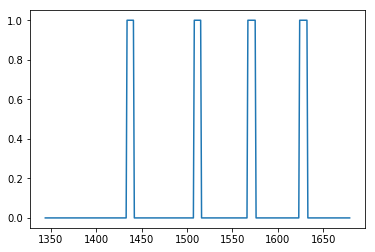

In [38]:
time = y_test.index.values
plt.plot(time, y_test)

In [41]:
time = y_train.index.values
plt.plot(time, y_train)

In [199]:
# Run this for MultiClassification
# Create empty lists to append to.
names = []
Event = []
Chance = []
Overlap = []
Lengths = []
Accuracy = []
TestAcc = []
Precision = []
Recall = []
Kappa = []

# Create test conditions to go into the loop
#test_Lengths = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0]
#overlaps = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

test_Lengths = [2.0]
overlaps = [0.5, 0.9]
list_Events = ['Stand_Free', 'Lift_Squat', 'Lower_Squat']
algorithms = ['LDA', 'KNN', 'NB', 'LR']
#cv = ShuffleSplit(5, test_size=0.2, random_state=42)
cv = KFold(5)
# Add stratified data split


events_Array = initialize_Event_Array(test_Lengths, overlaps, list_Events, algorithms, 120)

for my_Event in list_Events:
    for my_Epoch_Length in test_Lengths:
        for my_Overlap in overlaps:

            # Create dataset for machine learning
            labels = sliding_Window_Events(events, my_Epoch_Length, my_Overlap, 120)
            event = dummy_Events(labels)
            chosen_Event = event[my_Event] # 1-Stand_Free, 3-Lift_Squat, 5-Lower_Squat
            current_Event = my_Event
            #n = round(((number_Of_Samples - minL*sample_Rate)/(slide*sample_Rate)),0)-1
            data_Frame = pd.DataFrame(sliding_Window(data, events, my_Epoch_Length, my_Overlap, 120))
            data_Only = data_Frame[data_Frame.columns[2:]]

            # Define the parameters
            svcParameters = [{'gamma': 10.0 ** np.arange(-5, 4), 'C': 10.0 ** np.arange(-2, 7)}]
            ldaParameters = [{'n_components' : [10, 20, 30, 40], 'solver': ['svd', 'lsqr', 'eigen']}]
            knnParameters = [{'n_neighbors' : [5, 10, 15, 20]}]
            #artParameters = [{'max_features' : [2, 4, 6, 8, 10]}]
            #fParameters = [{'max_features': ["sqrt", "log2", None, 1], 'max_depth':[None, 15, 30, 50], 'min_samples_leaf': [2, 5, 10]}]

            # Assemble default classifiers
            svc = SVC(probability=True)
            lda = LinearDiscriminantAnalysis()
            knn = KNeighborsClassifier()
            #cart = DecisionTreeClassifier()
            nb = GaussianNB()
            qda = QuadraticDiscriminantAnalysis()
            lr = LogisticRegression()
            #rf = RandomForestClassifier()

            # Assemble grid parameter classifiers
            svc2 = GridSearchCV(SVC(probability=True), svcParameters, cv=cv, scoring='accuracy')
            lda2 = GridSearchCV(LinearDiscriminantAnalysis(), ldaParameters, cv=cv, scoring='accuracy')
            knn2 = GridSearchCV(KNeighborsClassifier(), knnParameters, cv=cv, scoring='accuracy')
            #cart2 = GridSearchCV(DecisionTreeClassifier(), cartParameters, cv=cv, scoring='accuracy')
            #nb2 = GridSearchCV(GaussianNB(), nbParameters, cv=cv, scoring='accuracy')
            #qda2 = GridSearchCV(QuadraticDiscriminantAnalysis(), qdaParameters, cv=cv, scoring='accuracy')
            #rf2 = GridSearchCV(RandomForestClassifier(), rfParameters, cv=cv, scoring='accuracy')
            
            # Split the test and train datasets
            for train_idx, test_idx in cv.split(labels):
                y_train, y_test = chosen_Event.loc[train_idx], chosen_Event.loc[test_idx]
                X_train, X_test = data_Only.loc[train_idx,:], data_Only.loc[test_idx,:]
                
            # Perform the machine learning
            currentName = algorithms
            #currentName = ['LDA']
            #classifier = [ Pipeline([('KNN', knn2)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            classifier = [Pipeline([('LDA', lda)]), Pipeline([('KNN', knn)]), Pipeline([('NB', nb)]), Pipeline([('QDA', qda)]), Pipeline([('LR', lr)])]
            #classifier = [Pipeline([('LDA', lda)])]
            count = 0
            for my_Classifier in classifier:
                sAccuracy = cross_val_score(my_Classifier, X_train, y_train, scoring = 'accuracy', cv=cv, n_jobs=1)

                # Printing the results
                labels = chosen_Event
                class_balance = np.mean(labels == labels[0])
                class_balance = np.mean(labels)
                class_balance = max(class_balance, 1. - class_balance)
                y_pred = my_Classifier.fit(X_train, y_train).predict(X_test)
                y_pred_prob = my_Classifier.predict_proba(X_test)
                #y_pred_class = binarize(y_pred_prob, 0.5)[:,0] # Predict events labeled as 1 not 2 which in this case is zero.

                rocTest = (1-y_test)+1
                #auc = roc_auc_score(rocTest, y_pred_class)
                tacc = accuracy_score(y_test, y_pred)
                prec = precision_score(y_test, y_pred)
                recall = recall_score(y_test, y_pred)
                kappa = cohen_kappa_score(y_test, y_pred)

                names.append(currentName[count])
                Event.append(current_Event)
                Lengths.append(my_Epoch_Length)
                Chance.append(class_balance)
                Overlap.append(my_Overlap)
                Accuracy.append(np.mean(sAccuracy))
                TestAcc.append(tacc)
                Precision.append(prec)
                Recall.append(recall)
                #AUC.append(auc)
                Kappa.append(kappa)
                count = count + 1
                
                header_Name = [my_Event, list(my_Classifier.named_steps.keys())[0], str(my_Epoch_Length), str(my_Overlap)]
                current_Column = '_'.join(header_Name)

            # Create a data frame that appends new columns
            # Reprint the events
            true_Events = y_test
            

#myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Chance' : Chance, 'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall, 'AUC' : AUC, 'Kappa': Kappa}
myData = {'Name' : names, 'Event': Event, 'Epochs' : Lengths, 'Overlap' : Overlap,  'Accuracy' : Accuracy, 'TestAcc' : TestAcc, 'Precision': Precision, 'Recall': Recall,  'Kappa': Kappa}

test5 = pd.DataFrame(myData, columns = ['Name', 'Event', 'Epochs', 'Overlap', 'Accuracy', 'TestAcc', 'Precision', 'Recall', 'Kappa'])
#test5.to_csv('testing.csv')

2

In [205]:
classifier[1]

TypeError: 'Pipeline' object is not subscriptable

In [223]:
jupyter nbconvert --to html Lifiting%20Coach%20Preliminary%20Analysis.ipynb

SyntaxError: invalid syntax (<ipython-input-223-781f60392dc7>, line 1)